# CS 20 : TensorFlow for Deep Learning Research
## Lecture 3 : Linear and Logistic Regression
### Linear Regression with huber loss by low-level

### Setup

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

1.8.0


### Load and Pre-process data

In [2]:
data = pd.read_table('../data/lec3_example_with_placeholder/birth_life_2010.txt')
data.head()

,Country,Birth rate,Life expectancy
0,Vietnam,1.822,74.828244
1,Vanuatu,3.869,70.819488
2,Tonga,3.911,72.150659
3,Timor-Leste,5.578,61.999854
4,Thailand,1.579,73.927659


In [3]:
x = data.loc[:,'Birth rate'].values
y = data.loc[:,'Life expectancy'].values
print(x.shape, y.shape)

(190,) (190,)


In [4]:
# split train and validation
tr_indices = np.random.choice(range(x.shape[0]), size = int(x.shape[0] * .7), replace=False)
x_tr = x[tr_indices]
y_tr = y[tr_indices]

x_val = np.delete(x, tr_indices, axis = 0)
y_val = np.delete(y, tr_indices, axis = 0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(133,) (133,)
(57,) (57,)


### Define the graph of Simple Linear Regression

In [5]:
# create placeholders for X (birth rate) and Y (life expectancy)
X = tf.placeholder(dtype = tf.float32, shape = [None])
Y = tf.placeholder(dtype = tf.float32, shape = [None])

# create weight and bias, initialized to 0 
w = tf.get_variable(name = 'weight', initializer = tf.constant(.0))
b = tf.get_variable(name = 'bias', initializer = tf.constant(.0))

# construct model to predict Y
yhat = X * w + b

# use the square error as huber loss function
residual = tf.abs(Y - yhat)
huber_loss = tf.cond(tf.reduce_mean(residual) <= 14.,
                     lambda : .5 * tf.reduce_mean(tf.square(residual)),
                     lambda : 14. * tf.reduce_mean(residual) - .5 * tf.square(14.))

huber_loss_summ = tf.summary.scalar(name = 'huber_loss', tensor = huber_loss) # for tensorboard

# using gradient descent with learning rate of 0.01 to minimize loss
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)
training_op = opt.minimize(huber_loss)

### Training

In [6]:
epochs = 100
batch_size = 8
total_step = int(x.shape[0] / batch_size)
print(total_step)

23


In [7]:
train_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/linreg_huber_low_tf_placeholder/train',
                                     graph = tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/linreg_huber_low_tf_placeholder/val',
                                     graph = tf.get_default_graph())

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_step):
        batch_indices = np.random.choice(range(x_tr.shape[0]),
                                         size = batch_size, replace = False)
        val_indices = np.random.choice(range(x_val.shape[0]),
                                       size = batch_size, replace = False)
        batch_xs = x_tr[batch_indices]
        batch_ys = y_tr[batch_indices]
        val_xs = x_val[val_indices]
        val_ys = y_val[val_indices]
        
        _, tr_loss = sess.run(fetches = [training_op, huber_loss],
                              feed_dict = {X : batch_xs, Y : batch_ys})
        tr_loss_summ = sess.run(huber_loss_summ, feed_dict = {X : batch_xs, Y : batch_ys})

        val_loss, val_loss_summ = sess.run(fetches = [huber_loss, huber_loss_summ],
                                           feed_dict = {X : val_xs, Y: val_ys})
        avg_tr_loss += tr_loss / total_step
        avg_val_loss += val_loss / total_step
        
    train_writer.add_summary(tr_loss_summ, global_step = epoch)
    val_writer.add_summary(val_loss_summ, global_step = epoch)
    
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if epoch % 10 == 0:
        print('epoch : {:3}, tr_loss : {:.2f}, val_loss : {:.2f}'.format(epoch, avg_tr_loss, avg_val_loss))

train_writer.close()
val_writer.close()

epoch :   0, tr_loss : 695.00, val_loss : 651.21
epoch :  10, tr_loss : 281.85, val_loss : 328.27
epoch :  20, tr_loss : 242.12, val_loss : 230.96
epoch :  30, tr_loss : 165.74, val_loss : 205.17
epoch :  40, tr_loss : 117.89, val_loss : 135.10
epoch :  50, tr_loss : 78.22, val_loss : 79.38
epoch :  60, tr_loss : 39.96, val_loss : 46.63
epoch :  70, tr_loss : 27.83, val_loss : 29.62
epoch :  80, tr_loss : 19.12, val_loss : 19.85
epoch :  90, tr_loss : 19.60, val_loss : 16.92


### Visualization

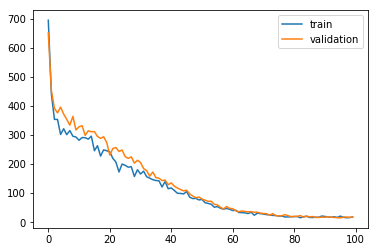

In [9]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

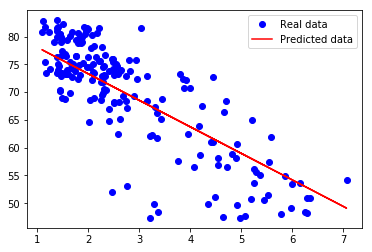

In [10]:
w_out, b_out = sess.run([w, b])
plt.plot(data.iloc[:,1], data.iloc[:,2], 'bo', label='Real data')
plt.plot(data.iloc[:,1], data.iloc[:,1] * w_out + b_out, 'r', label='Predicted data')
plt.legend()